In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
import copy
import PIL
import cv2
import numpy as np
from sklearn.model_selection import KFold
import random
import os
import numpy as np
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn import functional as F
import torchvision
from torchvision import datasets,transforms,models
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.dataset import Subset

from efficientnet_pytorch import EfficientNet

os.environ["CUDA_VISIBLE_DEVICES"]="1"

In [2]:
data_transforms = {
    'train': torchvision.transforms.Compose([
        transforms.RandomCrop((224,224)),
    # ランダムに画像を水平方向に反転
    transforms.RandomHorizontalFlip(),
    # ランダムに画像の色調を変更
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    # グレースケールに変換（3チャンネル出力）
    transforms.Grayscale(num_output_channels=3),
    torchvision.transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]),
    'test': torchvision.transforms.Compose([
        transforms.RandomCrop((224,224)),
    # ランダムに画像を水平方向に反転
    transforms.RandomHorizontalFlip(),
    # グレースケールに変換（3チャンネル出力）
    transforms.Grayscale(num_output_channels=3),
    torchvision.transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]),
}

train_data_dir = '/home/yamaguchi/データセットまとめ完成版 β/GCB Non-GCB MALT Normal　完成版/train'
valid_data_dir = '/home/yamaguchi/データセットまとめ完成版 β/GCB Non-GCB MALT Normal　完成版/test'

image_datasets = {
  'train': torchvision.datasets.ImageFolder(train_data_dir, transform=data_transforms['train']),
  'test': torchvision.datasets.ImageFolder(valid_data_dir, transform=data_transforms['test'])
}

dataloaders = {
  'train': torch.utils.data.DataLoader(image_datasets['train'], batch_size=32, shuffle=True),
  'test': torch.utils.data.DataLoader(image_datasets['test'], batch_size=32)
}

dataset_sizes = {
    'train': len(image_datasets['train']),
    'test': len(image_datasets['test'])
}

class_names = image_datasets['train'].classes

In [3]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

net_ft = EfficientNet.from_pretrained('efficientnet-b0', num_classes=4)

for param in net_ft.parameters():
    param.requires_grad = True  # Set to True for fine-tuning

net_ft = net_ft.to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net_ft.parameters(), lr=0.001, momentum=0.9)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

num_epochs = 100
acc_history_ft = {'train': [], 'test': []}

for epoch in range(num_epochs):

    for phase in ['train', 'test']:
        if phase == 'train':
            net_ft.train()
        else:
            net_ft.eval()

        running_loss = 0.0
        running_corrects = 0

        for inputs, labels in dataloaders[phase]:
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            with torch.set_grad_enabled(phase == 'train'):
                outputs = net_ft(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                if phase == 'train':
                    loss.backward()
                    optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

        epoch_loss = running_loss / dataset_sizes[phase]
        epoch_acc = running_corrects.double() / dataset_sizes[phase]
        acc_history_ft[phase].append(epoch_acc)


Loaded pretrained weights for efficientnet-b0


In [4]:
acc_history_ft['train'] = [x.cpu() for x in acc_history_ft['train']]
acc_history_ft['test'] = [x.cpu() for x in acc_history_ft['test']]

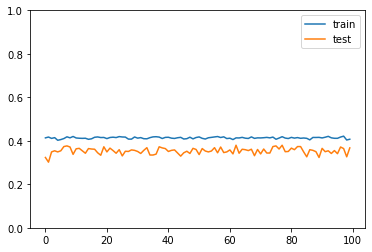

In [5]:
fig = plt.figure()
ax = fig.add_subplot()
ax.plot(acc_history_ft['train'], label='train')
ax.plot(acc_history_ft['test'], label='test')
ax.legend()
ax.set_ylim(0, 1)
fig.show()

In [6]:
print(net_ft)

EfficientNet(
  (_conv_stem): Conv2dStaticSamePadding(
    3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False
    (static_padding): ZeroPad2d((0, 1, 0, 1))
  )
  (_bn0): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
  (_blocks): ModuleList(
    (0): MBConvBlock(
      (_depthwise_conv): Conv2dStaticSamePadding(
        32, 32, kernel_size=(3, 3), stride=[1, 1], groups=32, bias=False
        (static_padding): ZeroPad2d((1, 1, 1, 1))
      )
      (_bn1): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
      (_se_reduce): Conv2dStaticSamePadding(
        32, 8, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_se_expand): Conv2dStaticSamePadding(
        8, 32, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_project_conv): Conv2dStaticSamePadding(
        32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False
    

In [7]:
import torchvision.transforms as T

def gradcam(net, img_fpath):
    net.eval()

    def __extract_grad(grad):
        global feature_grad
        feature_grad = grad

    img = PIL.Image.open(img_fpath).convert('RGB')
    transforms = T.Compose([
    T.RandomCrop((224,224)),
    # ランダムに画像を水平方向に反転
    T.RandomHorizontalFlip(),
    # ランダムに画像の色調を変更
    T.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    # グレースケールに変換（3チャンネル出力）
    T.Grayscale(num_output_channels=3),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    img = transforms(img)
    img = img.unsqueeze(0)

    # EfficientNet-B0の特徴抽出部分
    # 以下は一般的なEfficientNet-B0の構造を基にした例です。
    # あなたのモデルのアーキテクチャに合わせて調整が必要です。
    features = net.extract_features(img)
    features.register_hook(__extract_grad)

    # 全体のアーキテクチャを通じての出力
    x = net._avg_pooling(features)
    x = x.flatten(start_dim=1)
    output = net._dropout(x)
    output = net._fc(output)
    pred = torch.argmax(output).item()
    print(pred)

    # 出力の勾配を取得
    output[:, pred].backward()

    # チャネルにわたる勾配をプーリング
    pooled_grad = torch.mean(feature_grad, dim=[0, 2, 3])

    # 対応する勾配でチャネルを重み付け
    features = features.detach()
    for i in range(features.shape[1]):
        features[:, i, :, :] *= pooled_grad[i]

    # チャネルを平均してヒートマップを作成
    heatmap = torch.mean(features, dim=1).squeeze()
    heatmap = np.maximum(heatmap, 0)

    # プロット用に正規化
    heatmap = heatmap / torch.max(heatmap)
    heatmap = heatmap.numpy()

    # ヒートマップを入力画像に投影
    img = cv2.imread(img_fpath)
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    superimposed_img = heatmap * 0.4 + img
    superimposed_img = np.uint8(255 * superimposed_img / np.max(superimposed_img))
    superimposed_img = cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB)
    plt.imshow(superimposed_img)
    plt.show()

In [8]:
import glob
import cv2
import numpy as np
from PIL import Image

In [100]:
files =glob.glob('/home/yamaguchi/test1/*png')

3


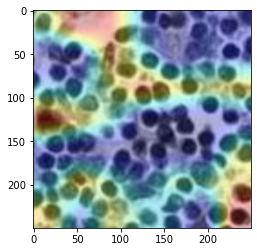

1


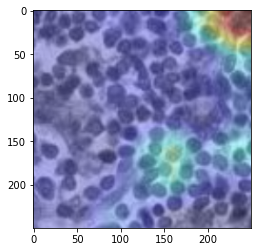

3


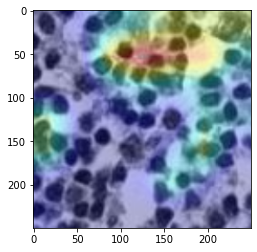

In [150]:
device = torch.device('cpu')
net_ft = net_ft.to(device)
for f in files:
    gradcam(net_ft,f)
  